# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/15TmB7LkIzWLPWP2is-iuqhFeybsKZOLZ?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:01<00:00, 105MB/s]


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

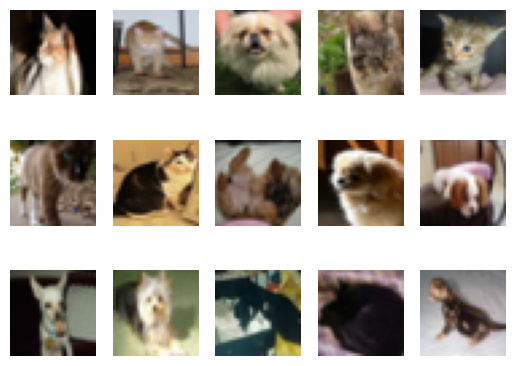

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [5]:
print("Number of training examples: {}".format(len(train_loader)))
print("Number of validation examples: {}".format(len(val_loader)))
print("Number of test examples: {}".format(len(test_loader)))

Number of training examples: 8000
Number of validation examples: 2000
Number of test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Answer:**

We need a validation set to get an unbiased evaluation of the model during training and to detect overfitting/underfitting. Using the training set error alone can be misleading as the model will naturally perform well on data it has already seen, potentially leading to overfitting where the model doesn't generalize well to new data. The validation set acts as a proxy for unseen data.



## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
print("small_net:")
for param in small_net.parameters():
    print(param.shape)

print()

print("large_net")
for param in large_net.parameters():
    print(param.shape)

small_net:
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

large_net
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


**Answer:**


* (5\*3\*3\*3)+(5)+(1\*245)+(1)=386

* (5\*3\*5\*5)+(5)+(10\*5\*5\*5)+(10)+(32\*250)+(32)+(1\*32)+(1)=9705


* There are **386** parameters in the small net, and **9705** parameters in the large net.

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [11]:
batch_size=64
learning_rate=0.01
num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [12]:
train_net(small_net,num_epochs=5)

Epoch 1: Train err: 0.432375, Train loss: 0.6764058194160462 |Validation err: 0.3785, Validation loss: 0.6579908803105354
Epoch 2: Train err: 0.370625, Train loss: 0.6472312378883361 |Validation err: 0.384, Validation loss: 0.6596634797751904
Epoch 3: Train err: 0.355625, Train loss: 0.6366147956848145 |Validation err: 0.353, Validation loss: 0.6287655308842659
Epoch 4: Train err: 0.341875, Train loss: 0.6221265025138855 |Validation err: 0.3495, Validation loss: 0.6207225974649191
Epoch 5: Train err: 0.332125, Train loss: 0.6116174993515014 |Validation err: 0.333, Validation loss: 0.6157749406993389
Finished Training
Total time elapsed: 23.77 seconds


**Answer:**

* checkpoints:
  * model_small_bs64_lr0.01_epoch0: checkpoint at epoch 0
  * model_small_bs64_lr0.01_epoch1: checkpoint at epoch 1
  * model_small_bs64_lr0.01_epoch2: checkpoint at epoch 2
  * model_small_bs64_lr0.01_epoch3: checkpoint at epoch 3
  * model_small_bs64_lr0.01_epoch4: checkpoint at epoch 4

* Train error/loss:
  * model_small_bs64_lr0.01_epoch4_train_err.csv: training error
  * model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss
  * model_small_bs64_lr0.01_epoch4_val_err.csv: validation error
  * model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [14]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
print("Training small_net")
small_net = SmallNet()
train_net(small_net)

print("Training large_net")
large_net = LargeNet()
train_net(large_net)

Training small_net
Epoch 1: Train err: 0.446375, Train loss: 0.6813716740608216 |Validation err: 0.3865, Validation loss: 0.660299738869071
Epoch 2: Train err: 0.37325, Train loss: 0.6497629313468933 |Validation err: 0.3845, Validation loss: 0.6575995795428753
Epoch 3: Train err: 0.360125, Train loss: 0.6389007897377014 |Validation err: 0.3495, Validation loss: 0.6291371881961823
Epoch 4: Train err: 0.346375, Train loss: 0.6246497564315796 |Validation err: 0.356, Validation loss: 0.6221635770052671
Epoch 5: Train err: 0.334125, Train loss: 0.6154210748672485 |Validation err: 0.328, Validation loss: 0.618933217599988
Epoch 6: Train err: 0.31775, Train loss: 0.6036666023731232 |Validation err: 0.3385, Validation loss: 0.6093297032639384
Epoch 7: Train err: 0.315875, Train loss: 0.5944248065948486 |Validation err: 0.328, Validation loss: 0.5973024442791939
Epoch 8: Train err: 0.308125, Train loss: 0.5829446413516999 |Validation err: 0.3085, Validation loss: 0.5884840954095125
Epoch 9: Tra

**Answer:**

Time for training small network is 141.55s, and for large network is 164.74s. Large network has much more parameters to update so it takes longer.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Network Plot: 


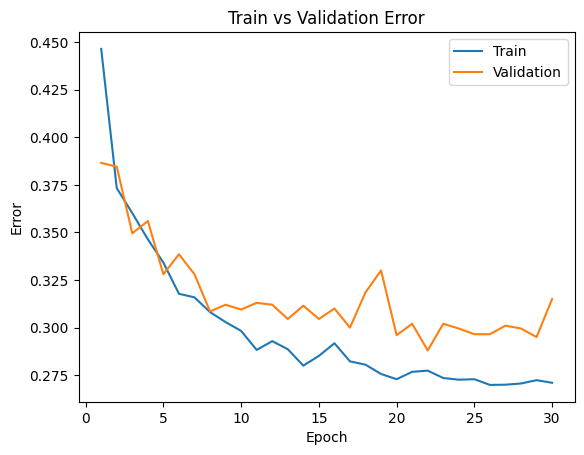

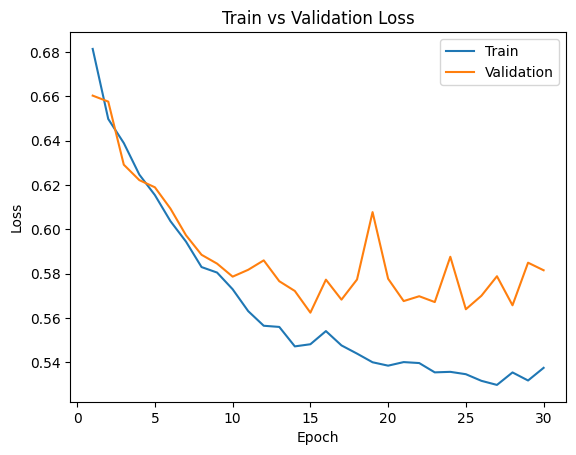

Large Network Plot: 


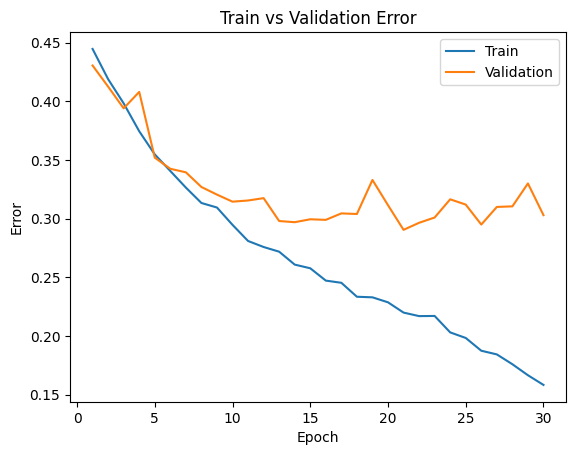

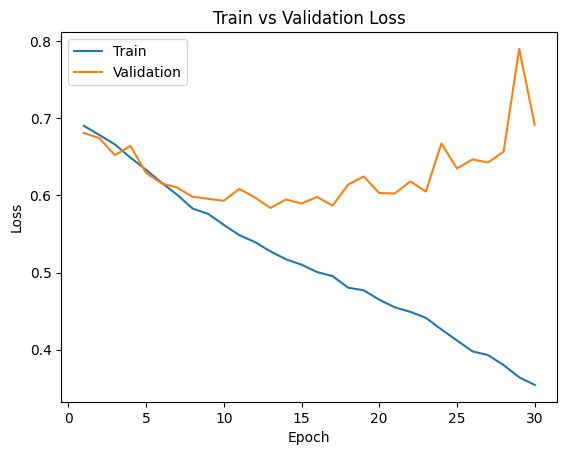

In [16]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

print("Small Network Plot: ")
plot_training_curve(small_path)
print("Large Network Plot: ")
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Answer:**

At first, both networks’ training and validation loss and error decrease steadily as the optimizer refines parameters, but around epoch 5 for the large net and epoch 10 for the small net the validation curves stop improving. The small network’s validation error and loss then plateau around the same level—indicating limited capacity and mild underfitting—while the large network’s validation loss actually rises even as its training error falls, signaling clear overfitting (i.e., the model memorizes the training set and fails to generalize).

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 0.4115, Validation loss: 0.6831991244107485
Epoch 9: Train err: 0.424375, Tr

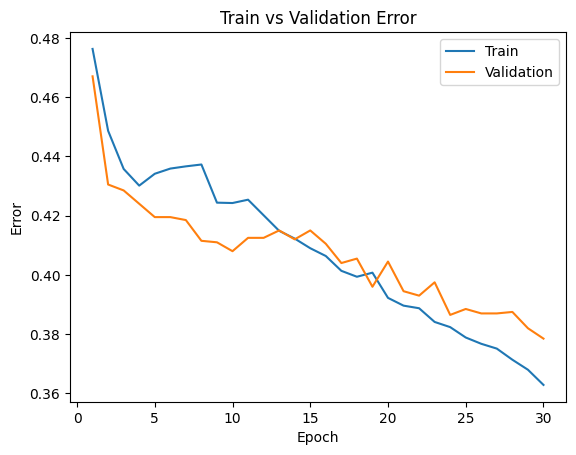

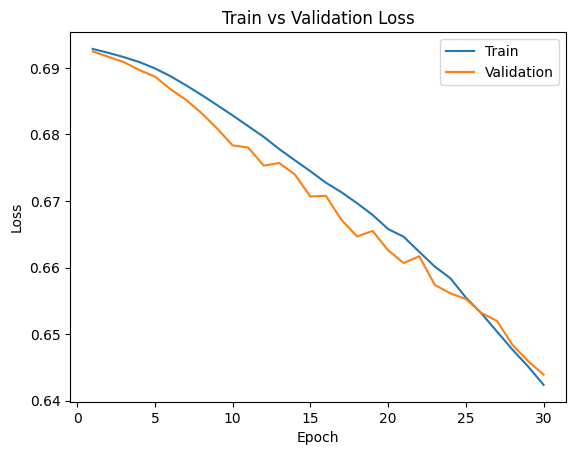

In [17]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
large_path = get_model_name("large", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_path)

**Answer:**

It runs 1.78 seconds longer than the default setting, this overall runtime are very similar. With a lower learning rate, training error and loss both increase, and validation error and loss rise as well. However, the training and validation curves are closer together, indicating that overfitting, as observed when the learning rate is 0.01, is avoided.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Epoch 1: Train err: 0.468, Train loss: 0.6859708547592163 |Validation err: 0.3915, Validation loss: 0.6671512890607119
Epoch 2: Train err: 0.38175, Train loss: 0.6535712971687316 |Validation err: 0.416, Validation loss: 0.6825554035604
Epoch 3: Train err: 0.355625, Train loss: 0.6300361003875733 |Validation err: 0.3315, Validation loss: 0.6121374126523733
Epoch 4: Train err: 0.33875, Train loss: 0.6164356069564819 |Validation err: 0.329, Validation loss: 0.6106978859752417
Epoch 5: Train err: 0.331625, Train loss: 0.6028243894577027 |Validation err: 0.322, Validation loss: 0.602822014130652
Epoch 6: Train err: 0.302875, Train loss: 0.5750768322944642 |Validation err: 0.318, Validation loss: 0.6768875233829021
Epoch 7: Train err: 0.306, Train loss: 0.579937388420105 |Validation err: 0.3195, Validation loss: 0.6036276603117585
Epoch 8: Train err: 0.302375, Train loss: 0.563445684671402 |Validation err: 0.346, Validation loss: 0.6068768594413996
Epoch 9: Train err: 0.2955, Train loss: 0.5

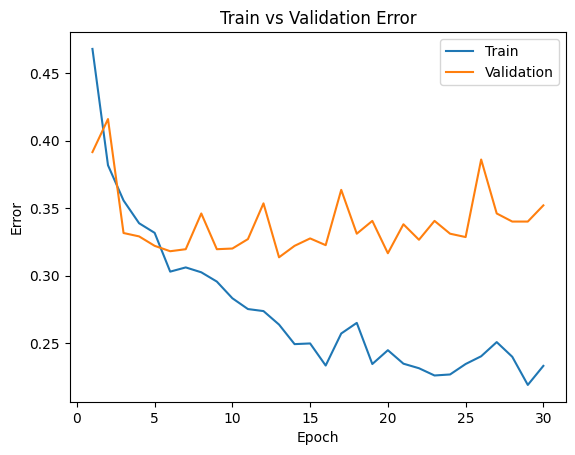

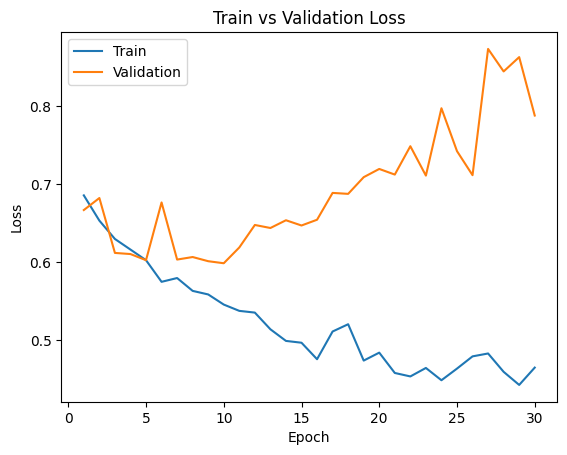

In [19]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
large_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_path)

**Answer:**

It takes about 7 seconds longer than the default setting, but overall runtime remains similar. Raising the learning rate from 0.01 to 0.1 causes larger gradient‐descent steps, so error and loss change more abruptly and overfitting appears earlier compared to the default model. As a result, the curves oscillate more and have sharper angles—indicating that a learning rate of 0.1 is too aggressive for this model.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Validation loss: 0.6814672648906708
Epoch 9: Train err: 0.42375, Train loss: 0.

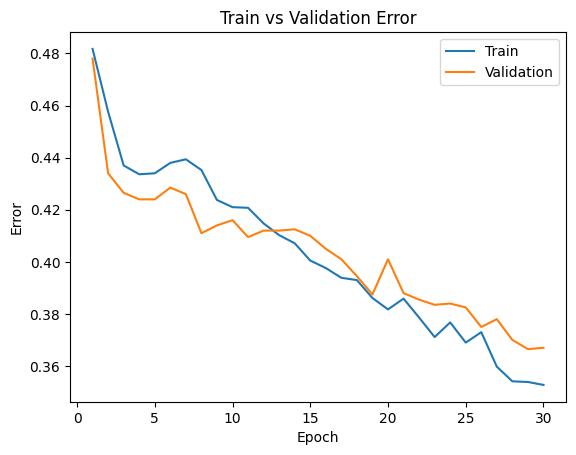

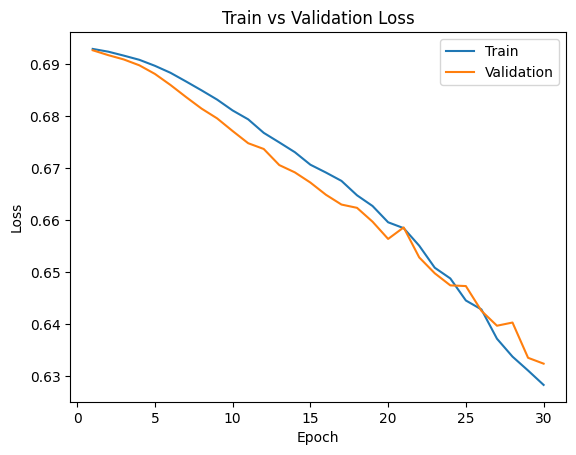

In [20]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
large_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

**Answer:**

With a larger batch size, training runs about 18 seconds faster since there are fewer iterations per epoch. Although the training error and loss are higher, the increased batch size reduces overfitting: the loss curves become smoother and the gap between training and validation curves narrows.


### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err: 0.326, Validation loss: 0.6016001827716827
Epoch 9: Train err: 0.249375, Tr

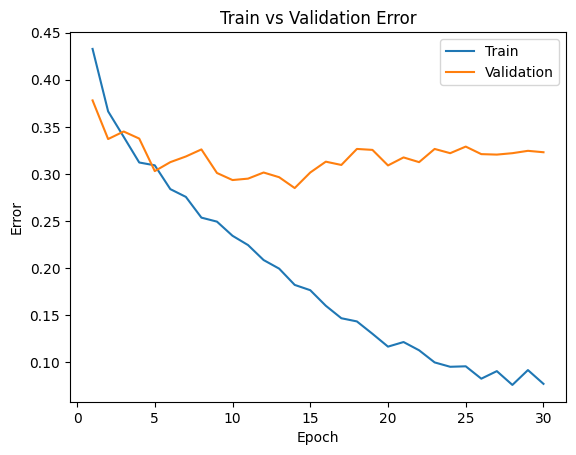

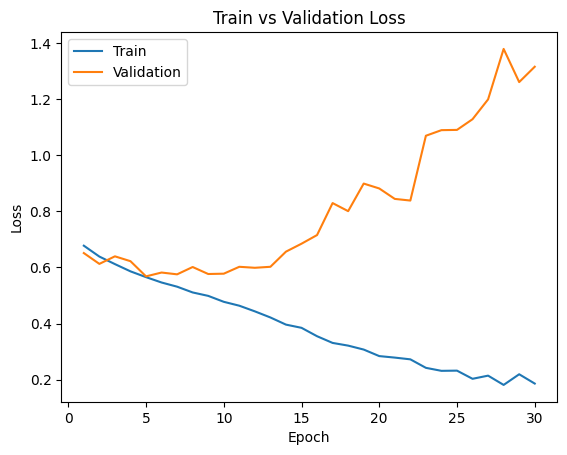

In [21]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)

large_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

Answer:

This takes around 61 seconds longer, decreasing the batch size increases training time since more iterations are needed per epoch. It does, however, lower the training error and loss and the overfitting occurs earlier. For validation, the error and loss is still large.








## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Answer:**

I would chose large network (with more parameters), large batch size, and small learning rate. So, I choose network = large_net; batch_size = 128, learning_rate = 0.01, and epoch = 30.


The large network outperforms the small network thanks to its greater parameter capacity. From Part 3, a learning rate of 0.01 proved to be well balanced. Small batch sizes tend to cause overfitting, so using a larger batch improves performance without overfitting. Finally, training for 30 epochs strikes a good balance between underfitting and overfitting.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Epoch 1: Train err: 0.454375, Train loss: 0.6920222280517457 |Validation err: 0.426, Validation loss: 0.6897575519979
Epoch 2: Train err: 0.44475, Train loss: 0.6877915528085496 |Validation err: 0.411, Validation loss: 0.6820644401013851
Epoch 3: Train err: 0.422125, Train loss: 0.6812269706574697 |Validation err: 0.412, Validation loss: 0.6738929860293865
Epoch 4: Train err: 0.41025, Train loss: 0.673797849624876 |Validation err: 0.4075, Validation loss: 0.6660339944064617
Epoch 5: Train err: 0.397375, Train loss: 0.6661591208170331 |Validation err: 0.4015, Validation loss: 0.6590236835181713
Epoch 6: Train err: 0.377125, Train loss: 0.6567326358386448 |Validation err: 0.3895, Validation loss: 0.6513406559824944
Epoch 7: Train err: 0.374625, Train loss: 0.6487630000190129 |Validation err: 0.3765, Validation loss: 0.639539323747158
Epoch 8: Train err: 0.36025, Train loss: 0.6365784785104176 |Validation err: 0.372, Validation loss: 0.6431583352386951
Epoch 9: Train err: 0.35, Train loss

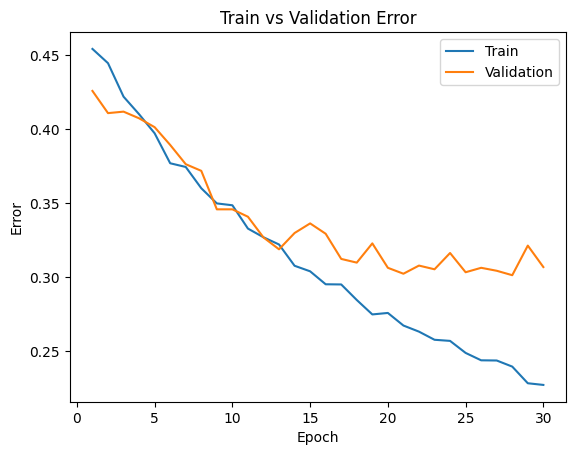

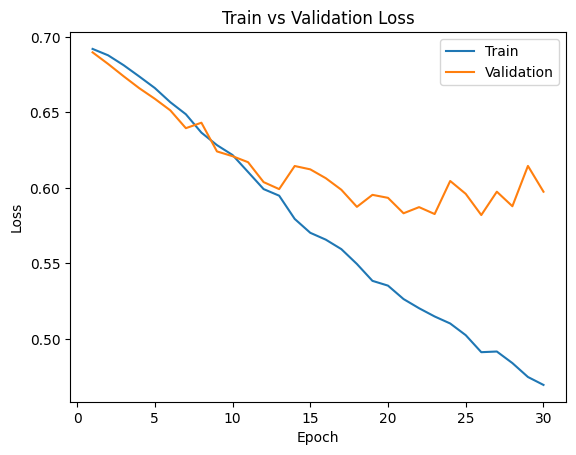

In [22]:
large_net = LargeNet()
train_net(large_net, 128, 0.01, 30)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

**Answer:**

I’ll use the large network with a batch size of 128, a learning rate of 0.005, and train for 50 epochs. I increased the epoch count to 50 to get more accurate data with less validation loss and error due to the smaller learning rate. Lowering the learning rate allows the model to make more precise parameter updates.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Epoch 1: Train err: 0.49775, Train loss: 0.6930236144671365 |Validation err: 0.5095, Validation loss: 0.6930284090340137
Epoch 2: Train err: 0.45725, Train loss: 0.6922709601266044 |Validation err: 0.42, Validation loss: 0.6916764788329601
Epoch 3: Train err: 0.433375, Train loss: 0.6913018368539356 |Validation err: 0.4115, Validation loss: 0.6902153231203556
Epoch 4: Train err: 0.427875, Train loss: 0.6897292752114553 |Validation err: 0.418, Validation loss: 0.6872660852968693
Epoch 5: Train err: 0.4315, Train loss: 0.6873460137654864 |Validation err: 0.418, Validation loss: 0.6837649568915367
Epoch 6: Train err: 0.427625, Train loss: 0.6840077771080865 |Validation err: 0.415, Validation loss: 0.6793228723108768
Epoch 7: Train err: 0.4185, Train loss: 0.679767336164202 |Validation err: 0.4035, Validation loss: 0.6747710406780243
Epoch 8: Train err: 0.40525, Train loss: 0.6748903526200188 |Validation err: 0.398, Validation loss: 0.6714272983372211
Epoch 9: Train err: 0.398875, Train lo

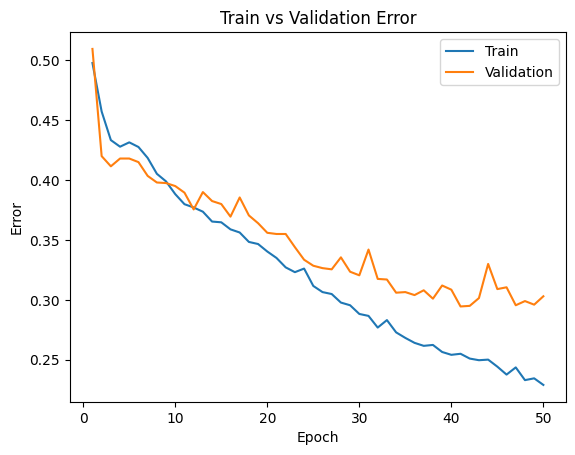

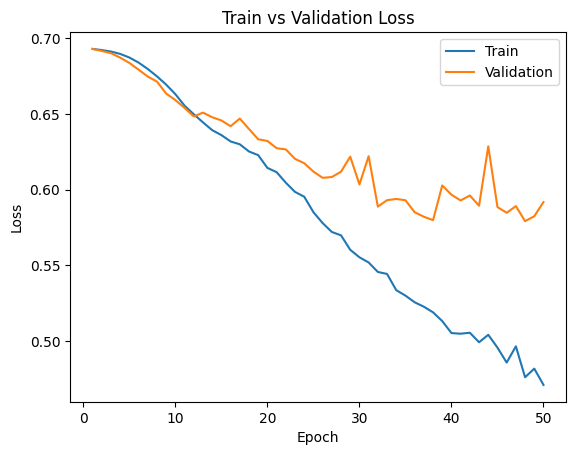

In [26]:
large_net = LargeNet()
train_net(large_net, 128, 0.005, 50)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.005, epoch=49)
plot_training_curve(model_path_large)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [27]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.005, epoch=49)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Answer:**

* Validation error from part(a): 0.303

* Validation loss from part(a): 0.591

Both the validation loss and error here are better than previous results.

I’m selecting the large network because its higher capacity yields lower validation error than the small network. Setting the batch size to 128 and the learning rate to 0.005 significantly reduces overfitting. With this lower learning rate, extending training to 50 epochs further refines the model, minimizing validation loss and error.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [32]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("The test classification error and loss are :", test_err, "and", test_loss)

The test classification error and loss are : 0.2855 and 0.5665808189660311


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**Answer:**

The test error (0.2855) is actually slightly lower than the validation error (0.303). In practice, one usually expects the test error to be a bit higher because hyperparameters are tuned to minimize validation loss—so the model has “seen” the validation set indirectly via that tuning. Here, though, the difference is small and likely just sampling noise: the particular split used for testing happened to be easier than the validation split.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer:**

We reserve the test set for the very end because it has never been used for training or validation, making it a true simulation of real‐world unseen data and an unbiased measure of final model performance. If we evaluate or tune on the test set during development, it effectively becomes part of the training process—leading to overfitting, where the model “remembers” the test examples rather than generalizing to new data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Epoch 1: Train err: 0.420125, Train loss: 0.673239356941647 |Validation err: 0.405, Validation loss: 0.6610617227852345
Epoch 2: Train err: 0.382625, Train loss: 0.651417494766296 |Validation err: 0.397, Validation loss: 0.653374370187521
Epoch 3: Train err: 0.369125, Train loss: 0.6399649864151364 |Validation err: 0.3865, Validation loss: 0.649825781583786
Epoch 4: Train err: 0.36025, Train loss: 0.6315847427125961 |Validation err: 0.396, Validation loss: 0.6539633125066757
Epoch 5: Train err: 0.35025, Train loss: 0.6255956140775529 |Validation err: 0.3855, Validation loss: 0.6451945528388023
Epoch 6: Train err: 0.3365, Train loss: 0.6164521328986637 |Validation err: 0.3805, Validation loss: 0.6481375768780708
Epoch 7: Train err: 0.329625, Train loss: 0.6098158993418255 |Validation err: 0.3795, Validation loss: 0.6461284793913364
Epoch 8: Train err: 0.32, Train loss: 0.6008976754688081 |Validation err: 0.368, Validation loss: 0.642281174659729
Epoch 9: Train err: 0.31875, Train loss: 

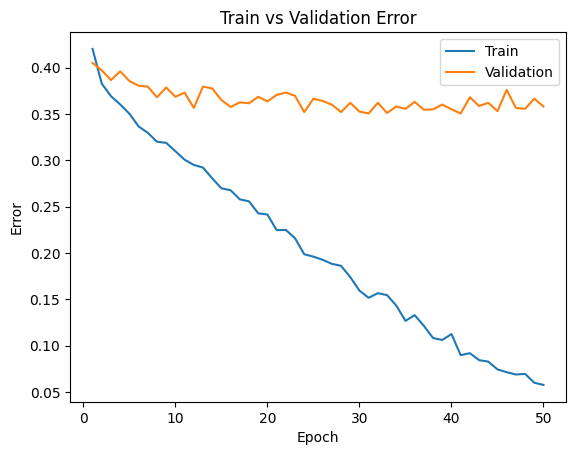

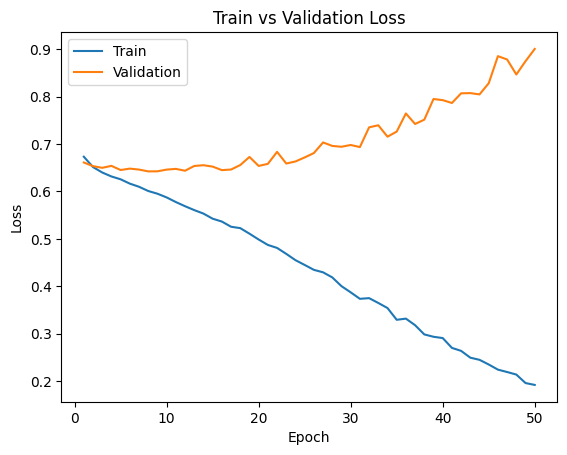

In [33]:
torch.manual_seed(1) #set random seed
class CatAndDog(nn.Module): # 2-layer artificial neural network
    def __init__(self):
        self.name = "CatAndDog"
        super(CatAndDog, self).__init__()
        self.layer1 = nn.Linear(3 * 32 * 32, 60)
        self.layer2 = nn.Linear(60, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

train_ANN = CatAndDog()
train_net(train_ANN, batch_size=128, learning_rate=0.005, num_epochs=50)

cdpath = get_model_name("CatAndDog", batch_size=128, learning_rate=0.005, epoch=49)
plot_training_curve(cdpath)

In [34]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

error, loss = evaluate(train_ANN, test_loader, nn.BCEWithLogitsLoss())
print("Test error is: ", error, ", and test loss is: ", loss)

error1, loss1 = evaluate(train_ANN, val_loader, nn.BCEWithLogitsLoss())
print("Validation error: ", error1, ", and validation loss: ", loss1)

Test error is:  0.3565 , and test loss is:  0.9038791991770267
Validation error:  0.358 , and validation loss:  0.9007261469960213


**Answer:**

The ANN model shows higher test error and loss, so the CNN model performs better.